Starting Antithetic Correlation Analysis for: batch_20251112_16-59-23

Processing Configuration: random_20N / stable
  Found 65 standard runs. Searching for pairs...


  - WARNING: PDR file not found, skipping: /home/damole/Documents/develop/SPE-project/results/batch_20251112_16-59-23/random_20N/stable/12405_antithetic/log_PDR.csv
  - WARNING: Skipping pair for seed 12405 due to file error.
  - WARNING: PDR file not found, skipping: /home/damole/Documents/develop/SPE-project/results/batch_20251112_16-59-23/random_20N/stable/12406/log_PDR.csv
  - WARNING: PDR file not found, skipping: /home/damole/Documents/develop/SPE-project/results/batch_20251112_16-59-23/random_20N/stable/12406_antithetic/log_PDR.csv
  - WARNING: Skipping pair for seed 12406 due to file error.
  - WARNING: PDR file not found, skipping: /home/damole/Documents/develop/SPE-project/results/batch_20251112_16-59-23/random_20N/stable/12407/log_PDR.csv
  - WARNING: PDR file not found, skipping: /home/damole/Documents/develop/SPE-project/results/batch_20251112_16-59-23/random_20N/stable/12407_antithetic/log_PDR.csv
  - WARNING: Skipping pair for seed 12407 due to file error.
  - WARNING: P


------------------------------
Correlation Analysis (PDR)
  (Based on 60 antithetic pairs)
  Correlation (r): -0.197901
  Mean Standard PDR:   0.7234
  Mean Antithetic PDR: 0.6957
  Mean Paired PDR:     0.7095
  StdDev Standard PDR:   0.2456
  StdDev Antithetic PDR: 0.1932
  StdDev Paired PDR:     0.1416 <-- This should be smallest!
------------------------------


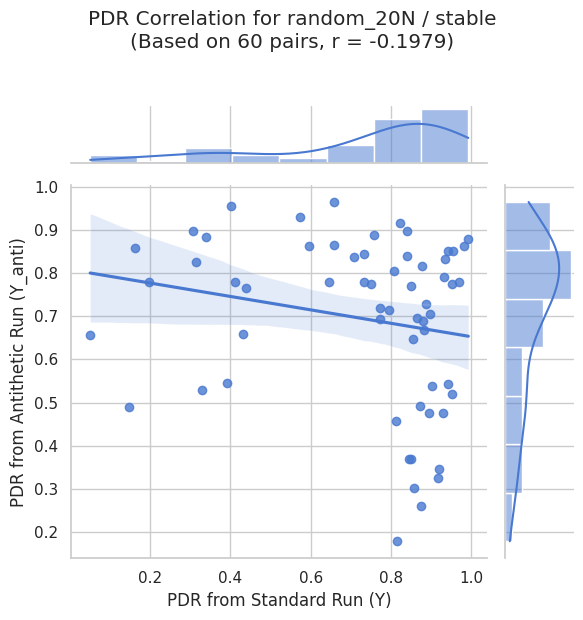



Antithetic analysis complete.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings

PATH_TO_RESULTS_BATCH_FOLDER = Path("/home/damole/Documents/develop/SPE-project/results/batch_20251112_16-59-23/")


# Log file names
PDR_LOG_FILE = "log_PDR.csv"
LATENCY_LOG_FILE = "log_e2eLat.csv"

sns.set(style="whitegrid", palette="muted")
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')

def process_pdr_file(file_path):

    try:
        df_pdr = pd.read_csv(file_path, skipinitialspace=True)
        
        if df_pdr.empty:

            return 0.0 
        
        if 'delivered' not in df_pdr.columns:
            print(f"  - ERROR: 'delivered' column not found in: {file_path}", file=sys.stderr)
            return None
            
        # The 'delivered' column is 0 or 1. The mean is the PDR.
        run_pdr = df_pdr['delivered'].mean()
        return run_pdr
    
    except FileNotFoundError:
        print(f"  - WARNING: PDR file not found, skipping: {file_path}", file=sys.stderr)
        return None
    except pd.errors.EmptyDataError:
        # File exists but is empty. Treat as PDR 0.0
        return 0.0
    except Exception as e:
        print(f"  - ERROR processing PDR file {file_path}: {e}", file=sys.stderr)
        return None


if not PATH_TO_RESULTS_BATCH_FOLDER.is_dir():
    print(f"ERROR: Batch directory not found at: {PATH_TO_RESULTS_BATCH_FOLDER}", file=sys.stderr)
    print("Please check your 'PATH_TO_RESULTS_BATCH_FOLDER' variable.", file=sys.stderr)
else:
    print(f"Starting Antithetic Correlation Analysis for: {PATH_TO_RESULTS_BATCH_FOLDER.name}\n")
    
    # Find topology folders
    topo_dirs = sorted([d for d in PATH_TO_RESULTS_BATCH_FOLDER.iterdir() if d.is_dir()])
    
    if not topo_dirs:
        print(f"  No topology folders found in {PATH_TO_RESULTS_BATCH_FOLDER}", file=sys.stderr)

    # --- Iterate over each Topology ---
    for topo_dir in topo_dirs:
        
        # Find channel folders (e.g., 'stable', 'lossy')
        channel_dirs = sorted([d for d in topo_dir.iterdir() if d.is_dir()])
        
        if not channel_dirs:
            print(f"  No channel folders found in {topo_dir}", file=sys.stderr)
            continue
            
        # --- Iterate over each Channel Configuration ---
        for channel_dir in channel_dirs:
            config_name = f"{topo_dir.name} / {channel_dir.name}"
            print("="*70)
            print(f"Processing Configuration: {config_name}")
            print("="*70)

            # --- Find pairs ---
            all_run_dirs = [d for d in channel_dir.iterdir() if d.is_dir()]
            
            # Find all standard runs (names are just digits)
            standard_run_dirs = sorted(
                [d for d in all_run_dirs if d.name.isdigit()],
                key=lambda x: int(x.name)
            )
            
            if not standard_run_dirs:
                print("  No standard seed runs (e.g., '12345') found. Cannot find pairs.")
                continue

            pdrs_standard = []
            pdrs_antithetic = []
            
            print(f"  Found {len(standard_run_dirs)} standard runs. Searching for pairs...")

            # --- Iterate over each Standard Run to find its partner ---
            for std_run_dir in standard_run_dirs:
                std_seed = std_run_dir.name
                anti_partner_name = f"{std_seed}_antithetic"
                anti_run_dir = channel_dir / anti_partner_name
                
                # Check if the antithetic partner exists
                if not anti_run_dir.is_dir():
                    print(f"  - WARNING: Found run {std_seed} but missing partner '{anti_partner_name}'. Skipping pair.", file=sys.stderr)
                    continue
                
                # --- We found a valid pair! Process both files ---
                pdr_file_std = std_run_dir / PDR_LOG_FILE
                pdr_file_anti = anti_run_dir / PDR_LOG_FILE
                
                run_pdr_std = process_pdr_file(pdr_file_std)
                run_pdr_anti = process_pdr_file(pdr_file_anti)
                
                # Only add the pair if BOTH files were processed correctly
                if run_pdr_std is not None and run_pdr_anti is not None:
                    pdrs_standard.append(run_pdr_std)
                    pdrs_antithetic.append(run_pdr_anti)
                else:
                    print(f"  - WARNING: Skipping pair for seed {std_seed} due to file error.", file=sys.stderr)

            # --- Analyze and Plot Correlation for this Configuration ---
            if len(pdrs_standard) < 2:
                print(f"\n  Not enough valid pairs found ({len(pdrs_standard)}) to calculate correlation. Need at least 2.")
            else:
                num_pairs = len(pdrs_standard)
                
                # Create a DataFrame to hold the paired data
                df_corr = pd.DataFrame({
                    'Standard_PDR': pdrs_standard,
                    'Antithetic_PDR': pdrs_antithetic
                })
                
                # Calculate the correlation matrix
                corr_matrix = df_corr.corr()
                
                # Get the single correlation value
                correlation = corr_matrix.loc['Standard_PDR', 'Antithetic_PDR']
                
                print("\n" + "-"*30)
                print(f"Correlation Analysis (PDR)")
                print(f"  (Based on {num_pairs} antithetic pairs)")
                print(f"  Correlation (r): {correlation:.6f}")
                print(f"  Mean Standard PDR:   {np.mean(pdrs_standard):.4f}")
                print(f"  Mean Antithetic PDR: {np.mean(pdrs_antithetic):.4f}")
                print(f"  Mean Paired PDR:     {df_corr.mean(axis=1).mean():.4f}")
                print(f"  StdDev Standard PDR:   {np.std(pdrs_standard):.4f}")
                print(f"  StdDev Antithetic PDR: {np.std(pdrs_antithetic):.4f}")
                print(f"  StdDev Paired PDR:     {df_corr.mean(axis=1).std():.4f} <-- This should be smallest!")
                print("-"*30)


                # --- Plot the Correlation ---
                # A jointplot is perfect: scatter + histograms
                plot = sns.jointplot(
                    data=df_corr, 
                    x='Standard_PDR', 
                    y='Antithetic_PDR', 
                    kind='reg' # 'reg' adds a regression line
                )
                plot.fig.suptitle(f'PDR Correlation for {config_name}\n(Based on {num_pairs} pairs, r = {correlation:.4f})', y=1.03)
                plot.set_axis_labels('PDR from Standard Run (Y)', 'PDR from Antithetic Run (Y_anti)')
                plt.tight_layout()
                plt.show() # Display the plot

        print("\n")

print("="*70)
print("Antithetic analysis complete.")

Avvio Analisi Correlazione Antitetica per: batch_20251112_16-59-23

Processo Configurazione: random_20N / stable
  Trovate 65 esecuzioni standard. Ricerca coppie...


  - WARNING: File latenza non trovato, skippato: /home/damole/Documents/develop/SPE-project/results/batch_20251112_16-59-23/random_20N/stable/12405_antithetic/log_e2eLat.csv
  - WARNING: Coppia skippata per il seed 12405 (dati mancanti, PDR=0?).
  - WARNING: File latenza non trovato, skippato: /home/damole/Documents/develop/SPE-project/results/batch_20251112_16-59-23/random_20N/stable/12406/log_e2eLat.csv
  - WARNING: File latenza non trovato, skippato: /home/damole/Documents/develop/SPE-project/results/batch_20251112_16-59-23/random_20N/stable/12406_antithetic/log_e2eLat.csv
  - WARNING: Coppia skippata per il seed 12406 (dati mancanti, PDR=0?).
  - WARNING: File latenza non trovato, skippato: /home/damole/Documents/develop/SPE-project/results/batch_20251112_16-59-23/random_20N/stable/12407/log_e2eLat.csv
  - WARNING: File latenza non trovato, skippato: /home/damole/Documents/develop/SPE-project/results/batch_20251112_16-59-23/random_20N/stable/12407_antithetic/log_e2eLat.csv
  - WARN


------------------------------
Analisi Correlazione Latenza (Medie per esecuzione)
  (Basata su 60 coppie antitetiche)
  Correlazione (r): -0.111991
  Covarianza:       -48.247613
  Mean Standard Latency:   8.1178
  Mean Antithetic Latency: 8.9570
  StdDev Standard Latency:   26.8967
  StdDev Antithetic Latency: 16.0174
  Var(Y_std):             723.4306
  Var((Y_std + Y_anti)/2): 220.8733
  RIDUZIONE VARIANZA OTTENUTA: 69.47%
------------------------------



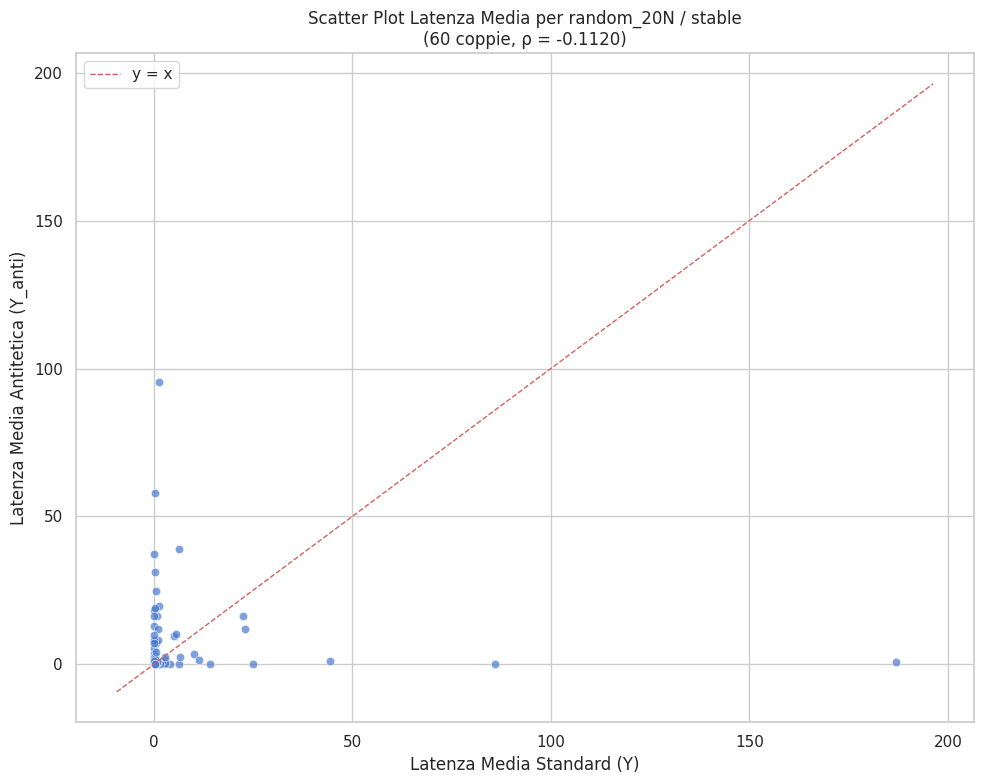



Analisi antitetica completata.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings
import json # Anche se non carichiamo parameters.json, è buona norma tenerlo

# =============================================================================
# --- Configurazione ---
# =============================================================================

# 1. Imposta questo alla *root* della tua cartella dei risultati batch
#    (ad esempio, la cartella chiamata 'batch_20251112_13-28-36')

# File di log (come definito in run_simulation.py)
LATENCY_LOG_FILE = "log_e2eLat.csv"

# Imposta lo stile del plot
sns.set(style="whitegrid", palette="muted")
# Sopprimi i warning di seaborn
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')

# =============================================================================
# --- Funzione Helper ---
# =============================================================================

def process_latency_file(file_path: Path) -> float:
    """
    Legge un singolo file di log E2ELatency da un'esecuzione (seed).
    Calcola la latenza MEDIA per quell'esecuzione.
    Restituisce il valore (float) o np.nan se il file non è valido o è vuoto.
    """
    try:
        df_lat = pd.read_csv(file_path, skipinitialspace=True)
        
        if df_lat.empty or 'latency' not in df_lat.columns:
            # PDR era 0, quindi nessun pacchetto consegnato.
            # Non possiamo calcolare una latenza media.
            return np.nan
            
        # Calcola e restituisce la latenza media per questa esecuzione
        run_latency_mean = df_lat['latency'].mean()
        return run_latency_mean
    
    except FileNotFoundError:
        print(f"  - WARNING: File latenza non trovato, skippato: {file_path}", file=sys.stderr)
        return np.nan
    except pd.errors.EmptyDataError:
        # File esiste ma è vuoto (PDR 0)
        return np.nan
    except Exception as e:
        print(f"  - ERRORE processando {file_path}: {e}", file=sys.stderr)
        return np.nan

# =============================================================================
# --- Script di Analisi Principale ---
# =============================================================================

def main():
    if not PATH_TO_RESULTS_BATCH_FOLDER.is_dir():
        print(f"ERRORE: Cartella batch non trovata: {PATH_TO_RESULTS_BATCH_FOLDER}", file=sys.stderr)
        print("Controlla la variabile 'PATH_TO_RESULTS_BATCH_FOLDER'.", file=sys.stderr)
        return

    print(f"Avvio Analisi Correlazione Antitetica per: {PATH_TO_RESULTS_BATCH_FOLDER.name}\n")
    
    # Trova le cartelle delle topologie (es. 'linear_20N', 'random_20N')
    topo_dirs = sorted([d for d in PATH_TO_RESULTS_BATCH_FOLDER.iterdir() if d.is_dir()])
    
    if not topo_dirs:
        print(f"  Nessuna cartella di topologia trovata in {PATH_TO_RESULTS_BATCH_FOLDER}", file=sys.stderr)
        return

    # --- Itera su ogni Topologia ---
    for topo_dir in topo_dirs:
        
        # Trova le cartelle dei canali (es. 'stable', 'lossy')
        channel_dirs = sorted([d for d in topo_dir.iterdir() if d.is_dir()])
        
        if not channel_dirs:
            print(f"  Nessuna cartella di canale trovata in {topo_dir}", file=sys.stderr)
            continue
            
        # --- Itera su ogni Configurazione di Canale ---
        for channel_dir in channel_dirs:
            config_name = f"{topo_dir.name} / {channel_dir.name}"
            print("="*70)
            print(f"Processo Configurazione: {config_name}")
            print("="*70)

            # Trova tutte le esecuzioni
            all_run_dirs = [d for d in channel_dir.iterdir() if d.is_dir()]
            
            # Trova tutte le esecuzioni "standard" (nomi sono solo numeri)
            standard_run_dirs = sorted(
                [d for d in all_run_dirs if d.name.isdigit()],
                key=lambda x: int(x.name)
            )
            
            if not standard_run_dirs:
                print("  Nessuna esecuzione standard (es. '12345') trovata. Impossibile trovare coppie.")
                continue

            latencies_standard = []
            latencies_antithetic = []
            
            print(f"  Trovate {len(standard_run_dirs)} esecuzioni standard. Ricerca coppie...")

            # --- Itera su ogni Esecuzione Standard per trovare il partner ---
            for std_run_dir in standard_run_dirs:
                std_seed = std_run_dir.name
                anti_partner_name = f"{std_seed}_antithetic"
                anti_run_dir = channel_dir / anti_partner_name
                
                # Controlla se il partner antitetico esiste
                if not anti_run_dir.is_dir():
                    print(f"  - WARNING: Trovata esecuzione {std_seed} ma manca il partner '{anti_partner_name}'. Coppia skippata.", file=sys.stderr)
                    continue
                
                # --- Coppia valida trovata! Processa entrambi i file. ---
                lat_file_std = std_run_dir / LATENCY_LOG_FILE
                lat_file_anti = anti_run_dir / LATENCY_LOG_FILE
                
                run_lat_std = process_latency_file(lat_file_std)
                run_lat_anti = process_latency_file(lat_file_anti)
                
                # Aggiungi la coppia solo se ENTRAMBI i file sono stati processati correttamente
                # (np.isnan torna False per None)
                if not np.isnan(run_lat_std) and not np.isnan(run_lat_anti):
                    latencies_standard.append(run_lat_std)
                    latencies_antithetic.append(run_lat_anti)
                else:
                    print(f"  - WARNING: Coppia skippata per il seed {std_seed} (dati mancanti, PDR=0?).", file=sys.stderr)

            # --- Analizza e Plotta la Correlazione per questa Configurazione ---
            if len(latencies_standard) < 2:
                print(f"\n  Trovate meno di 2 coppie valide ({len(latencies_standard)}). Impossibile calcolare la correlazione.\n")
            else:
                num_pairs = len(latencies_standard)
                
                # Crea un DataFrame per i dati appaiati
                df_corr = pd.DataFrame({
                    'Standard_Latency_Mean': latencies_standard,
                    'Antithetic_Latency_Mean': latencies_antithetic
                })
                
                # Calcola la matrice di correlazione
                corr_matrix = df_corr.corr()
                cov_matrix = df_corr.cov()
                
                # Ottieni i singoli valori
                correlation = corr_matrix.loc['Standard_Latency_Mean', 'Antithetic_Latency_Mean']
                covariance = cov_matrix.loc['Standard_Latency_Mean', 'Antithetic_Latency_Mean']
                
                print("\n" + "-"*30)
                print(f"Analisi Correlazione Latenza (Medie per esecuzione)")
                print(f"  (Basata su {num_pairs} coppie antitetiche)")
                print(f"  Correlazione (r): {correlation:.6f}")
                print(f"  Covarianza:       {covariance:.6f}")
                print(f"  Mean Standard Latency:   {df_corr['Standard_Latency_Mean'].mean():.4f}")
                print(f"  Mean Antithetic Latency: {df_corr['Antithetic_Latency_Mean'].mean():.4f}")
                print(f"  StdDev Standard Latency:   {df_corr['Standard_Latency_Mean'].std():.4f}")
                print(f"  StdDev Antithetic Latency: {df_corr['Antithetic_Latency_Mean'].std():.4f}")
                
                # Varianza della media delle coppie
                # (Y_i + Y_anti_i) / 2
                var_paired_mean = ((df_corr['Standard_Latency_Mean'] + df_corr['Antithetic_Latency_Mean']) / 2).var()
                # Varianza della media standard
                var_std_mean = df_corr['Standard_Latency_Mean'].var()
                
                print(f"  Var(Y_std):             {var_std_mean:.4f}")
                print(f"  Var((Y_std + Y_anti)/2): {var_paired_mean:.4f}")
                if var_paired_mean < var_std_mean and correlation < 0:
                    reduction = (1 - (var_paired_mean / var_std_mean)) * 100
                    print(f"  RIDUZIONE VARIANZA OTTENUTA: {reduction:.2f}%")
                else:
                    print("  ATTENZIONE: Nessuna riduzione della varianza ottenuta.")
                print("-"*30 + "\n")


                # --- Plotta la Correlazione ---
                plt.figure(figsize=(10, 8))
                ax = sns.scatterplot(data=df_corr, x='Standard_Latency_Mean', y='Antithetic_Latency_Mean', alpha=0.7)
                
                # Linea y=x
                lims = [
                    min(ax.get_xlim()[0], ax.get_ylim()[0]),
                    max(ax.get_xlim()[1], ax.get_ylim()[1]),
                ]
                ax.plot(lims, lims, "r--", linewidth=1, label="y = x")
                
                ax.set_xlabel("Latenza Media Standard (Y)")
                ax.set_ylabel("Latenza Media Antitetica (Y_anti)")
                ax.set_title(
                    f"Scatter Plot Latenza Media per {config_name}\n"
                    f"({num_pairs} coppie, ρ = {correlation:.4f})"
                )
                ax.legend()
                plt.tight_layout()
                plt.show() # Mostra il plot

        print("\n")

    print("="*70)
    print("Analisi antitetica completata.")


if __name__ == "__main__":
    main()